# Introduction
Inspired by predicting sales of things dependent of multivariate observations (eg day of week, holidays) and so on

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf


In [16]:
from sklearn.model_selection._split import _BaseKFold
from pandas import DataFrame
from statsmodels.regression.linear_model import RegressionResults
from sklearn.metrics import mean_absolute_error, median_absolute_error
# ------- LIBARRY functions ---------
import numpy as np
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMAResults
# LIBRARY
from seaborn import histplot, relplot, lineplot
from pandas import Series
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf

class TimeSeriesSplitWrapper(_BaseKFold):
    def __init__(self, n_last_test_items:int, **kwargs):
        self.n_last_test_items = n_last_test_items
        self.splitter_ = TimeSeriesSplit(**kwargs)

    def split(self, X=None, y=None, groups=None):
        for train, test in self.splitter_.split(X):
            yield (train, test[-self.n_last_test_items:])

def plot_series_hist_acf_kpss(data: Series, lags=5, plot_lag_plot=False, hist_bins=15):
    # Yt
    f = relplot(data=data, kind='line', markers=True, height=20.0, aspect=1.5)
    plt.show()

    # ACF
    f = plot_acf(data, lags=lags)
    plt.show()

    ax = histplot(data, bins=hist_bins, kde=True)
    plt.show()

    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
    kpss_stat = kpss(data, store=True)    # hypothesis: constant
    print("KPSS={}".format(kpss_stat))# around a mean

    # Compare median and mean
    print(data.describe())

    # Lag plot
    if (plot_lag_plot is True):
        ax = lag_plot(series=data, lag=lags)
        plt.show()

# Actual vs Fitted
def plot_actual_and_fitted_values(y: Series, model_fit: ARIMAResults):
    fitted_ = model_fit.fittedvalues[y.index]
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    f = lineplot(data=pd.DataFrame({'actual': y, 'fitted': fitted_}), ax=axes)
    plt.show()


def errors(y: Series, y_pred: Series):
    diff_ = (y - y_pred)
    return {
        'RMSE': np.sqrt(mean_squared_error(y, y_pred, squared=True)),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MEDIAN_AE': median_absolute_error(y, y_pred),
        'MAX_ABS': diff_.abs().max(),
        'MIN_ABS': diff_.abs().min()}

def model_errors_precalculated(res: RegressionResults):
    return {
        'RMSE / standard error (SE)': np.sqrt(res.mse_resid),  # https://otexts.com/fpp3/least-squares.html#standard-error-of-the-regression
        'RSQUARED': res.rsquared,
        'RSQUARED-ADJUSTED': res.rsquared_adj
    }


def model_errors(y: Series, model_fit: ARIMAResults):
    fitted:Series = model_fit.fittedvalues[y.index]
    return errors(y, fitted)

def plot_residuals_against_predictors(model_fit: RegressionResults, predictors: DataFrame):
    x_y = predictors.assign(Sales=model_fit.resid)
    f = pairplot(data=x_y, y_vars=['Sales'], x_vars=x_y.columns, height=20)
    plt.show()


def plot_fitted_against_residuals(model_fit: RegressionResults):
    f = scatterplot(x=model_fit.fittedvalues, y=model_fit.resid)
    plt.xlabel("FITTED")
    plt.ylabel("RESIDUALS")
    plt.show()


# Preprocessing
Feature engineering, create categorial columns

In [17]:
import pandas as pd
from pandas import DataFrame

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def enginner_categorial_dummy(x: DataFrame, col: str):
    """
    Creates dummy columns of col named 'col' of X matrix
    :param x:
    :param col:
    :return:
    """
    s_cat = x[col].astype('category')
    x = pd.concat([x, pd.get_dummies(s_cat, prefix=col, dtype=float)], axis=1)
    return x

def engineer_outliers_dummy(x: DataFrame, y:Series):

    """
    Handle Sales == 0 as outlier and set "outlier" column as dummy variable to 1 and everything else to zero.
    See here why (https://otexts.com/fpp3/useful-predictors.html#dummy-variables)
    :return:
    """
    s_sales_zero_bin: Series = y == 0.0
    # set all columns to zero except outlier
    x[s_sales_zero_bin.to_numpy()] = 0.0

    return x.assign(Outlier=s_sales_zero_bin.astype('float'))

df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': float, 'Promo': float, 'SchoolHoliday': float})
# get data for one store
# FEATURE ENGINEERING
df_train = df_train.groupby(by='Store').get_group(2).set_index('Date').sort_index()

## StateHoliday -> categorial
df_train = enginner_categorial_dummy(df_train, 'StateHoliday')

## Day of week -> categorial
df_train = enginner_categorial_dummy(df_train, 'DayOfWeek')
df_train['Month'] = df_train.index.month
dummies = pd.get_dummies(df_train['Month'], prefix='Month', dtype=float)
df_train = pd.concat([df_train, dummies], axis=1)

df_train.info()
df_train.head(5)

X = df_train[['Promo',
              'SchoolHoliday',
              'StateHoliday_0',
              'StateHoliday_a',
              'StateHoliday_b',
              'StateHoliday_c',
              'DayOfWeek_2',
              'DayOfWeek_3',
              'DayOfWeek_4',
              'DayOfWeek_5',
              'DayOfWeek_6',
              'DayOfWeek_7',
              'Month_2',
              'Month_3',
              'Month_4',
              'Month_5',
              'Month_6',
              'Month_7',
              'Month_8',
              'Month_9',
              'Month_10',
              'Month_11',
              'Month_12']].astype('float')
Y = df_train['Sales'].astype('float')

X = engineer_outliers_dummy(X, Y)

X.assign(Sales=Y).info()
X.assign(Sales=Y).head(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Store           942 non-null    int64  
 1   DayOfWeek       942 non-null    int64  
 2   Sales           942 non-null    int64  
 3   Customers       942 non-null    int64  
 4   Open            942 non-null    float64
 5   Promo           942 non-null    float64
 6   StateHoliday    942 non-null    object 
 7   SchoolHoliday   942 non-null    float64
 8   StateHoliday_0  942 non-null    float64
 9   StateHoliday_a  942 non-null    float64
 10  StateHoliday_b  942 non-null    float64
 11  StateHoliday_c  942 non-null    float64
 12  DayOfWeek_1     942 non-null    float64
 13  DayOfWeek_2     942 non-null    float64
 14  DayOfWeek_3     942 non-null    float64
 15  DayOfWeek_4     942 non-null    float64
 16  DayOfWeek_5     942 non-null    float64
 17  DayOfWeek_6     

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHoliday_0,StateHoliday_a,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2,2,0,0,0.0,0.0,a,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,2,3,4422,650,1.0,0.0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,2,4,4159,555,1.0,0.0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,2,5,4484,574,1.0,0.0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,2,6,2342,324,1.0,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Promo           942 non-null    float64
 1   SchoolHoliday   942 non-null    float64
 2   StateHoliday_0  942 non-null    float64
 3   StateHoliday_a  942 non-null    float64
 4   StateHoliday_b  942 non-null    float64
 5   StateHoliday_c  942 non-null    float64
 6   DayOfWeek_2     942 non-null    float64
 7   DayOfWeek_3     942 non-null    float64
 8   DayOfWeek_4     942 non-null    float64
 9   DayOfWeek_5     942 non-null    float64
 10  DayOfWeek_6     942 non-null    float64
 11  DayOfWeek_7     942 non-null    float64
 12  Month_2         942 non-null    float64
 13  Month_3         942 non-null    float64
 14  Month_4         942 non-null    float64
 15  Month_5         942 non-null    float64
 16  Month_6         942 non-null    float64
 17  Month_7         

,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,...,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Outlier,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-02,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4422.0
2013-01-03,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4159.0
2013-01-04,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4484.0
2013-01-05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2342.0
2013-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-07,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6775.0
2013-01-08,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6318.0
2013-01-09,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6763.0


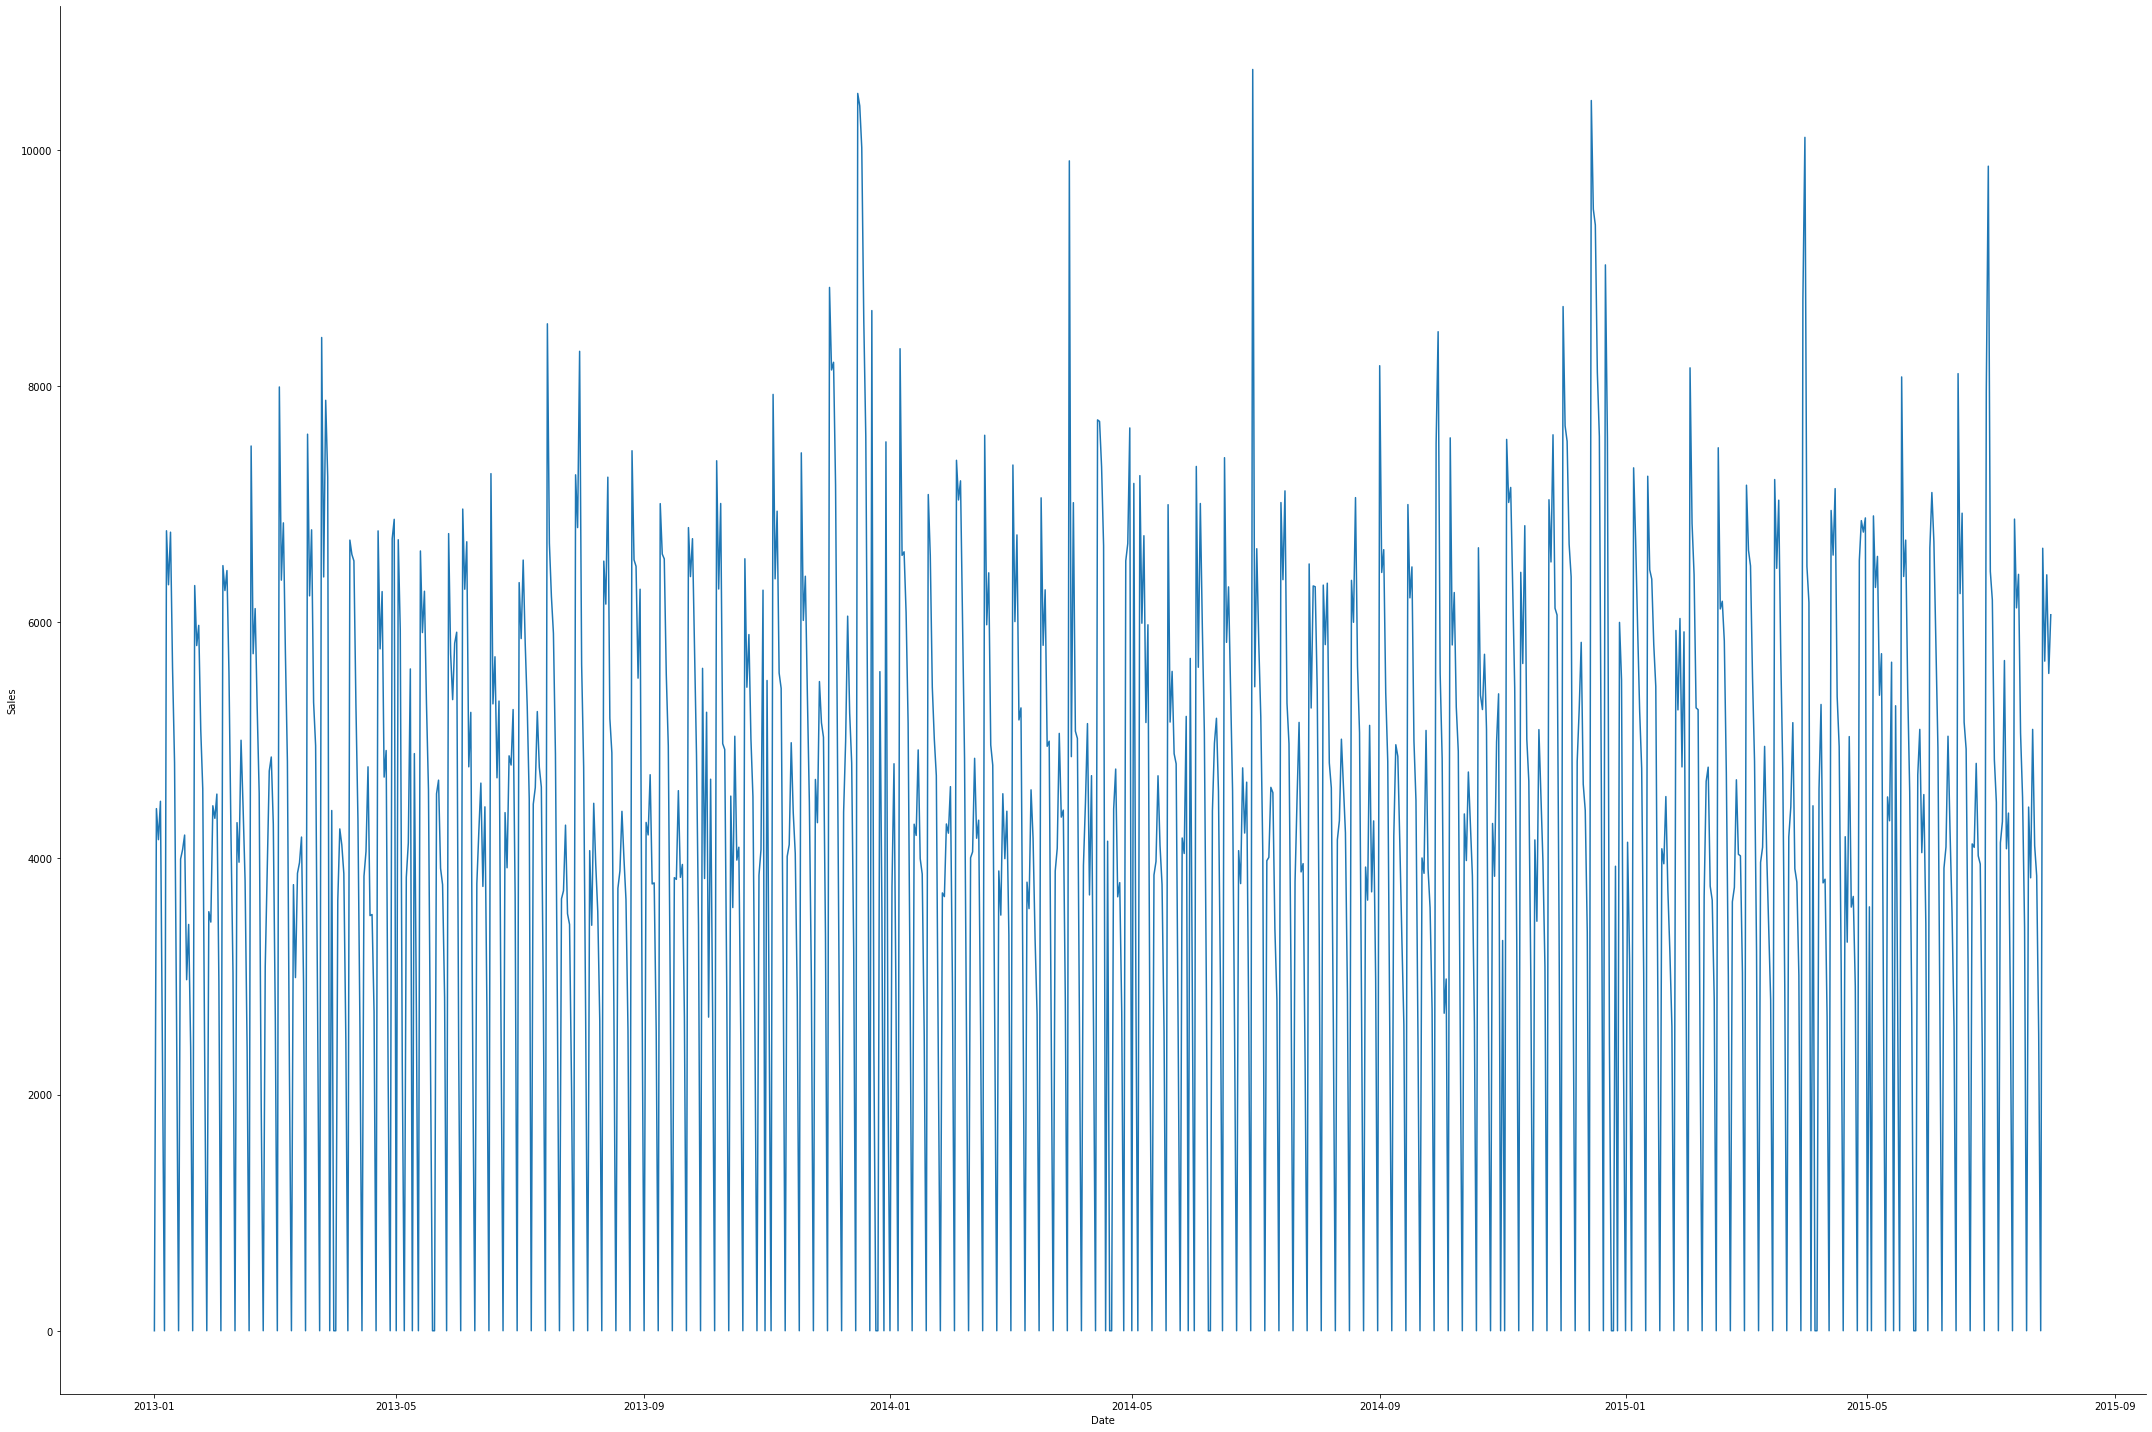

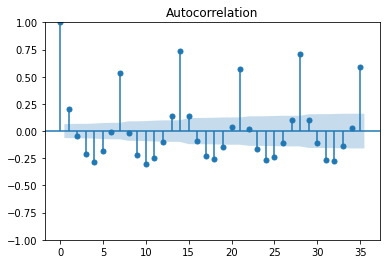

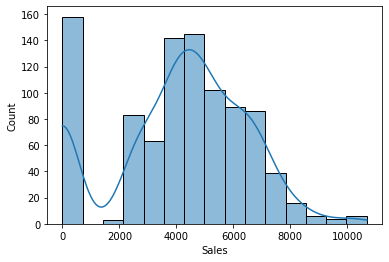

KPSS=(0.30030540241246695, 0.1, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, <statsmodels.stats.diagnostic.ResultsStore object at 0x7fe1d5759310>)
count      942.000000
mean      4122.991507
std       2363.628674
min          0.000000
25%       2806.750000
50%       4395.500000
75%       5804.500000
max      10682.000000
Name: Sales, dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [18]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

plot_series_hist_acf_kpss(Y, lags=35)

# Forecast | Oridinary least squares (statsmodels)
Naively assume we can forecast by OLS and interpret the residuals of the model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     508.6
Date:                Sun, 05 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:22:33   Log-Likelihood:                -7481.4
No. Observations:                 942   AIC:                         1.500e+04
Df Residuals:                     921   BIC:                         1.511e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Promo           1966.8595     54.402     36.154      0.000    1860.093    2073.626
SchoolHoliday    120.4046     74.501      1.616      0.106     -25.807     266.617
StateHoliday_0  4660.6321    101.369     45.977      0.000    4461.691    4859.574
StateHoliday_a  2866.6939    509.517      5.626      0.000    1866.745    3866.642
StateHoliday_b  6.037e-12   8.49e-13      7.115      0.000    4.37e-12     7.7e-12
StateHoliday_c  1.864e-12   4.02e-13      4.642      0.000    1.08e-12    2.65e-12
DayOfWeek_2     -638.6373     85.143     -7.501      0.000    -805.734    -471.540
DayOfWeek_3     -149.6685     85.511     -1.750      0.080    -317.487      18.150
DayOfWeek_4    -1022.2420     86.427    -11.828      0.000   -1191.858    -852.626
DayOfWeek_5    -1274.6147     86.130    -14.799      0.000   -1443.649   -1105.581
DayOfWeek_6    -2031.4215     92.412    -21.982      0.000   -2212.784   -1850.059
DayOfWeek_7    -1.056e-13   4.11e-14     -2.571      0.010   -1.86e-13    -2.5e-14
Month_2           64.7590    112.948      0.573      0.567    -156.906     286.424
Month_3          309.9427    110.653      2.801      0.005      92.782     527.103
Month_4          178.7040    112.782      1.585      0.113     -42.635     400.043
Month_5          216.0570    112.569      1.919      0.055      -4.865     436.979
Month_6          280.5906    111.498      2.517      0.012      61.770     499.411
Month_7          154.6012    112.787      1.371      0.171     -66.747     375.950
Month_8          -40.4652    131.631     -0.307      0.759    -298.796     217.866
Month_9          167.0032    124.168      1.345      0.179     -76.682     410.688
Month_10         -29.1953    126.524     -0.231      0.818    -277.505     219.114
Month_11         403.3530    124.081      3.251      0.001     159.838     646.868
Month_12        1520.2497    126.114     12.055      0.000    1272.746    1767.753
Outlier         8.114e-13     54.766   1.48e-14      1.000    -107.481     107.481
==============================================================================
Omnibus:                      167.256   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1777.693
Skew:                           0.457   Prob(JB):                         0.00
Kurtosis:                       9.668   Cond. No.                     2.19e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.46e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

------ Residual diagnostics --------


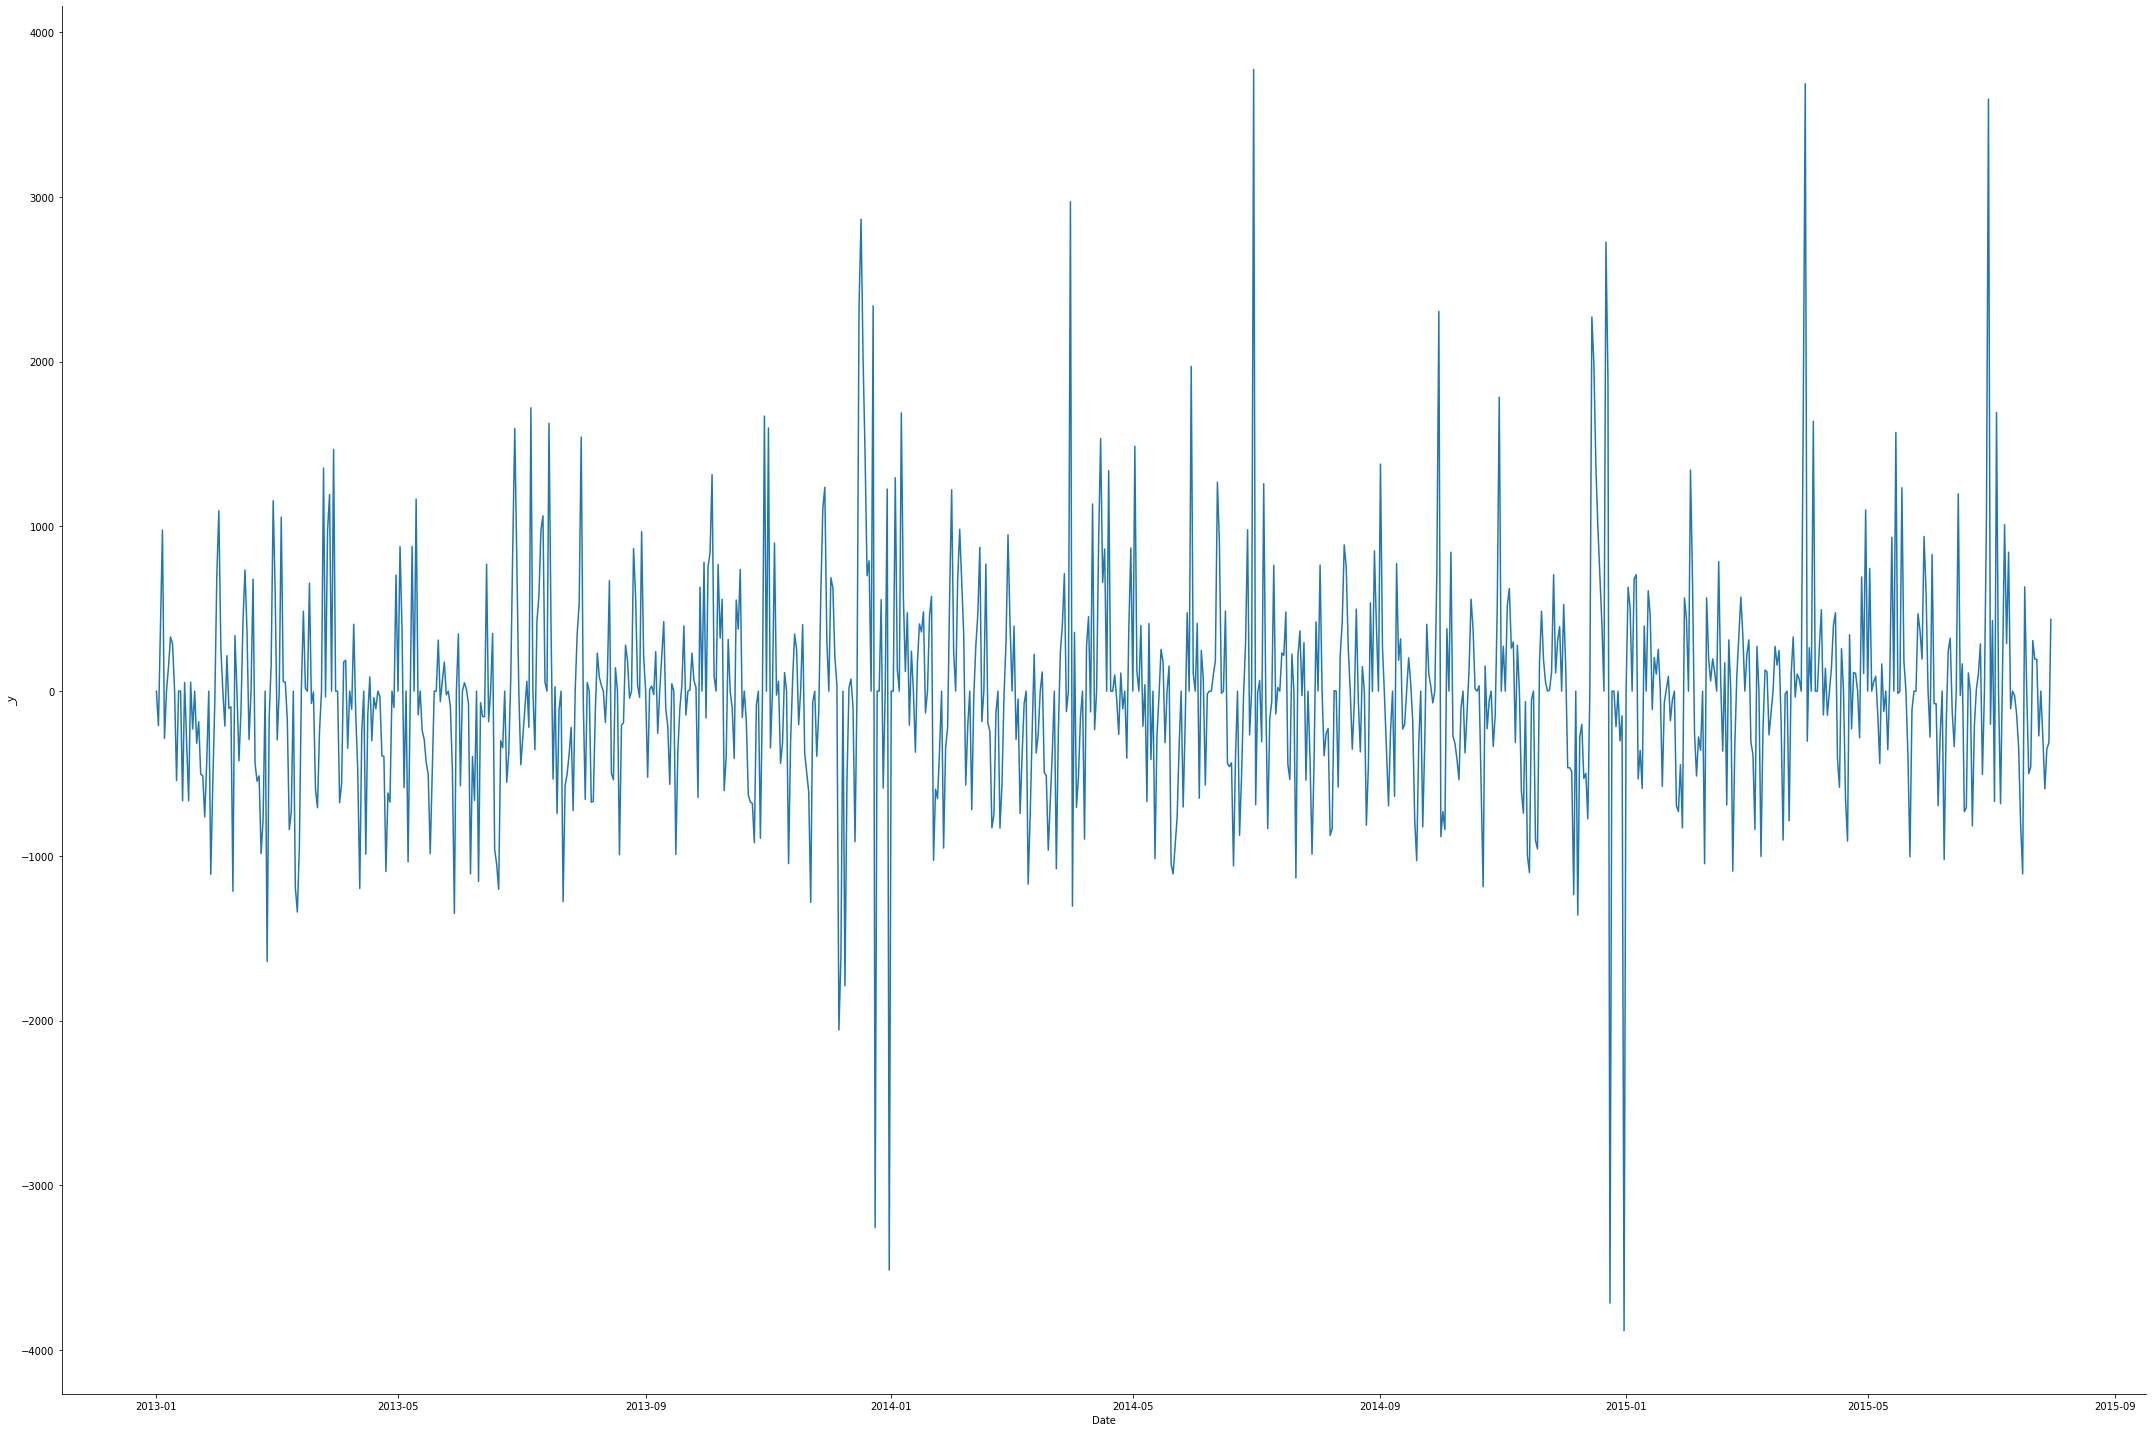

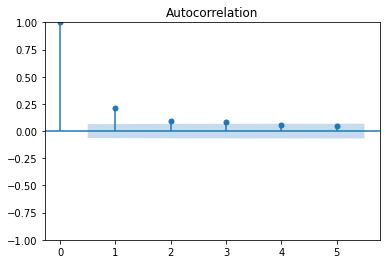

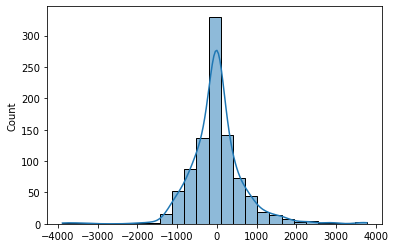

KPSS=(0.22455972555483783, 0.1, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, <statsmodels.stats.diagnostic.ResultsStore object at 0x7fe1f372e340>)
count    9.420000e+02
mean    -4.711607e-13
std      6.810457e+02
min     -3.882618e+03
25%     -3.311322e+02
50%     -8.113687e-13
75%      2.533221e+02
max      3.773918e+03
dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


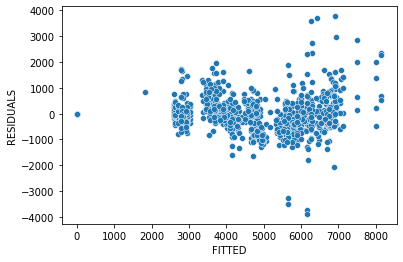

------ Actual vs fitted --------


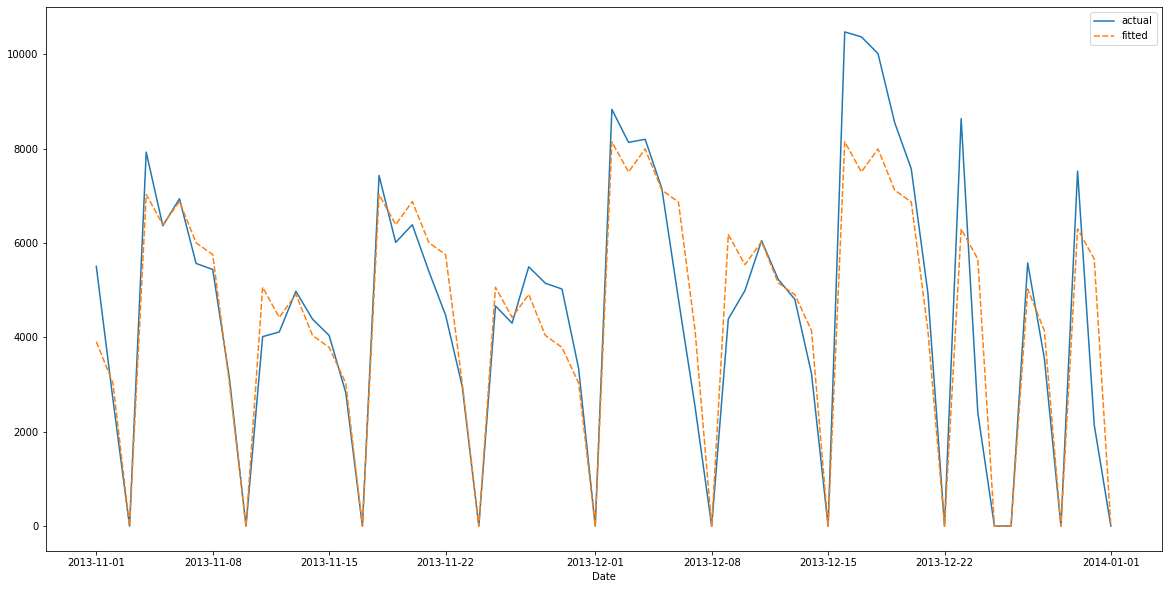

{'RMSE': 680.6841139150753,
 'MAPE': 612.9861037623048,
 'MAE': 436.8994500581721,
 'MEDIAN_AE': 293.9102578621471,
 'MAX_ABS': 3882.617899371263,
 'MIN_ABS': 8.113687480046493e-13}

------ Model errors --------


{'RMSE / standard error (SE)': 688.4006175910367,
 'RSQUARED': 0.9169778436160478,
 'RSQUARED-ADJUSTED': 0.9151749737705765}

------ Statsmodels accuracy (Cross validation) --------


In [19]:
from sklearn.metrics import make_scorer
from sklearn.linear_model._base import LinearModel
from typing import Iterator, Iterable
from sklearn.feature_selection import SelectKBest, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from seaborn import  pairplot, scatterplot
from statsmodels.regression.linear_model import OLS, RegressionResults, PredictionResults

model: OLS = OLS(endog=Y, exog=X)
model_fit: RegressionResults = model.fit(disp=False)

# Interpretation of coefficient statistics (https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/regression/supporting-topics/regression-models/what-is-the-standard-error-of-the-coefficient/)
# Interpretation of t-statistics: https://dss.princeton.edu/online_help/analysis/interpreting_regression.htm
model_fit.summary()
#model_fit.get_prediction()

print('------ Residual diagnostics --------')
plot_series_hist_acf_kpss(model_fit.resid, hist_bins=25)


plot_fitted_against_residuals(model_fit)
#plot_residuals_against_predictors(model_fit, X)

print('------ Actual vs fitted --------')
plot_actual_and_fitted_values(Y['2013-11':'2014-01-01'], model_fit)

model_errors(Y, model_fit)
print('------ Model errors --------')
model_errors_precalculated(model_fit)

print('------ Statsmodels accuracy (Cross validation) --------')
def model_accuracy_statsmodels(model_creator, x: DataFrame, y: Series, cv: Iterable[tuple[DataFrame, DataFrame]], plot: bool = False):
    # n_splits x train/test sets with test_size x test oberservations each
    for train_idx, test_idx in cv:

        y_train = y.iloc[train_idx]
        y_test  = y.iloc[test_idx]
        x_train = x.iloc[train_idx]
        x_test  = x.iloc[test_idx]

        model: OLS = model_creator(y_train, x_train)
        fit_result: RegressionResults = model.fit()

        predict_result: PredictionResults = fit_result.get_prediction(exog=x_test)
        print(predict_result.summary_frame())

        print(errors(y=y_test, y_pred=predict_result.predicted_mean))
        #print(y_test)

#model_accuracy_statsmodels(lambda y, x: OLS(endog=y, exog=x), X, Y, cv=TimeSeriesSplit(n_splits=3, test_size=1).split(X))

# Forecast | Linear regression using least squares (scikit)
Using iterative methods for feature selection will finds features leading to the model with the best predictive accuracy cause univariate (each feature significance to the dependent variable only) and model based (analysis of amount of coeffiecients and errors does not see correlation between them and measures its importance only feature by feature).
See [here](https://otexts.com/fpp3/selecting-predictors.html) for more details.

In [43]:
from collections import namedtuple
from sklearn.metrics._scorer import r2_scorer, neg_mean_squared_error_scorer
from sklearn.linear_model import LinearRegression

def select_best_features_until(x: DataFrame, y: Series, cv, scorer, n_features_to_select_threshold=4, direction='backward'):
    '''
    Yields back named tuples with
    score := max score of current count of features over all cross validations
    n_features := count of features
    :param n_features_to_select:
    :param direction:
    :return:
    '''
    Result = namedtuple('FeatureSelectResult', 'score n_features column_names')

    def feature_count_iterator():
        if direction == 'backward':
            return range(n_features_to_select_threshold, x.columns.size)
        return range(1, n_features_to_select_threshold)

    for i in feature_count_iterator():
        model = LinearRegression()
        sfs: SequentialFeatureSelector = SequentialFeatureSelector(model,
                                                                   n_features_to_select=i,
                                                                   scoring=scorer,
                                                                   #scoring=make_scorer(mean_squared_error, squared=False, greater_is_better=False),
                                                                   cv=cv,
                                                                   direction=direction,
                                                                   n_jobs=6)
        x_selected = sfs.fit_transform(X, y=Y)
        x_selected_column_names = X.columns[sfs.get_support()]

        score_mean: float = cross_val_score(model, X=x_selected, y=y, scoring=scorer, cv=cv).mean()
        yield Result(score=score_mean, column_names=x_selected_column_names, n_features=x_selected_column_names.size)

def model_accuracy_scikit(model: LinearRegression, x: DataFrame, y: Series, cv: Iterable[tuple], scorer=r2_scorer):
    # n_splits x train/test sets with test_size x test oberservations each

    scores = cross_val_score(estimator=model, X=x, y=y,
                             cv=cv,
                             scoring=scorer)
    #scoring=make_scorer(mean_squared_error, squared=False, greater_is_better=True))  # Returns -1*RMSE == std deviation to have a the higher the score the better

    print('Scores %s' % format(scores))
    print('Scores statistics %s' % format(Series(scores).describe()))
    #print(errors(y=y_test, y_pred=predict_result.predicted_mean))

# Train: Last 6 months with last 7 days of next month each as test data set
#cv_splitter = test_splitter(X, n_splits=6, test_size=31, n_last_test_items=7)
cv_splitter = TimeSeriesSplitWrapper(n_last_test_items=7, n_splits=12, test_size=31)

print('------ Scikit | Accuracy using all features --------')

model_accuracy_scikit(LinearRegression(), X, Y, cv_splitter)   # using 7 consequtive days
model_accuracy_scikit(LinearRegression(), X, Y, cv_splitter, scorer=make_scorer(mean_squared_error, greater_is_better=False, squared=False))   # using 7 consequtive days
# model_accuracy_scikit(LinearRegression(), X, Y, cv_splitter, scorer=make_scorer(mean_absolute_percentage_error, greater_is_better=False))   # using 7 consequ

print('------ Scikit | Iterate over multiple amount of features and select with best accuracy --------')

result_ = DataFrame(select_best_features_until(X, Y, scorer=r2_scorer, n_features_to_select_threshold=10, cv=cv_splitter, direction='forward')).set_index(keys='score', drop=False)
result_
print('Feature set with high score [{}]'.format(result_.loc[result_['score'].max()]))

# todo:
# 1. Features correlated a lot of each other remove before going on (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2)
# 2. Use CV (create scorer impl using scikit's LeaveOneOut() splitter)  vs SSE or R² of residuals (https://otexts.com/fpp3/selecting-predictors.html#cross-validation)
# 3. Use model based SelectFromModel or https://otexts.com/fpp3/selecting-predictors.html and compare to iterative approach

#model_accuracy_scikit(LinearRegression(), X, Y, [()])

# correlation matrix
#print('Correlation Matrix (features pairwise, method pearson)')
#X.assign(Open=df_train['Open']).corr(method='pearson')  # see which vars are dependent of each other and could be removed
#print('Correlation Matrix (features -> Sales, method pearson)')
#X.corrwith(Y, method='pearson')




------ Scikit | Accuracy using all features --------
Scores [0.98486255 0.87386064 0.93154318 0.99306982 0.69944083 0.97397509
 0.86760285 0.95131433 0.97931668 0.92081277 0.77485584 0.97230143]
Scores statistics count    12.000000
mean      0.910246
std       0.092084
min       0.699441
25%       0.872296
50%       0.941429
75%       0.975310
max       0.993070
dtype: float64
Scores [ -282.51496484  -591.20627292  -557.15745402  -181.10612516
 -1920.19329384  -275.13581062  -544.28999459  -341.96867024
  -338.86907501  -571.5057805  -1453.43553594  -382.8486273 ]
Scores statistics count      12.000000
mean     -620.019300
std       525.358010
min     -1920.193294
25%      -576.430904
50%      -463.569311
75%      -324.780547
max      -181.106125
dtype: float64
------ Scikit | Iterate over multiple amount of features and select with best accuracy --------


,score,n_features,column_names
score,,,
0.598336,0.598336,1,"Index(['Outlier'], dtype='object')"
0.805537,0.805537,2,"Index(['Promo', 'Outlier'], dtype='object')"
0.856408,0.856408,3,"Index(['Promo', 'DayOfWeek_6', 'Outlier'], dty..."
0.878190,0.878190,4,"Index(['Promo', 'DayOfWeek_5', 'DayOfWeek_6', ..."
0.895448,0.895448,5,"Index(['Promo', 'DayOfWeek_5', 'DayOfWeek_6', ..."
0.906391,0.906391,6,"Index(['Promo', 'DayOfWeek_4', 'DayOfWeek_5', ..."
0.909655,0.909655,7,"Index(['Promo', 'DayOfWeek_4', 'DayOfWeek_5', ..."
0.911547,0.911547,8,"Index(['Promo', 'DayOfWeek_4', 'DayOfWeek_5', ..."
0.913367,0.913367,9,"Index(['Promo', 'DayOfWeek_4', 'DayOfWeek_5', ..."


Feature set with high score [score                                                    0.913367
n_features                                                      9
column_names    Index(['Promo', 'DayOfWeek_4', 'DayOfWeek_5', ...
Name: 0.9133670643810845, dtype: object]
